In [1]:
import functools
import itertools
import math

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import shapefile
import shapely.geometry
import s2cell

# Helper functions

In [2]:
def lat_lon_to_face_uv(lat, lon):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    sin_lat_rad = math.sin(lat_rad)
    cos_lat_rad = math.cos(lat_rad)
    sin_lon_rad = math.sin(lon_rad)
    cos_lon_rad = math.cos(lon_rad)

    s2_point = (
        cos_lat_rad * cos_lon_rad,  # X
        cos_lat_rad * sin_lon_rad,  # Y
        sin_lat_rad                 # Z
    )

    face = int(np.argmax(np.abs(s2_point)))  # Largest absolute component
    if s2_point[face] < 0.0:
        face += 3

    uv = (
        s2_point[1 - ((face + 1) >> 1)] / s2_point[face % 3],  # U
        s2_point[2 - (face >> 1)] / s2_point[face % 3]         # V
    )
    if face in (1, 2, 5):
        uv = (-uv[0], uv[1])  # Negate U
    if face in (2, 4, 5):
        uv = (uv[0], -uv[1])  # Negate V

    return face, uv

In [3]:
def face_to_uv_offset(face):
    if face == 0:
        return (0, 0)
    elif face == 1:
        return (2, 0)
    elif face == 2:
        return (2, 2)
    elif face == 3:
        return (4, 2)
    elif face == 4:
        return (4, 4)
    else:
        return (6, 4)

# Load common data

In [4]:
with shapefile.Reader('ne_50m_admin_0_countries_lakes.shp') as sf:
    shapes = [
        shapely.geometry.shape(shape) for shape in sf.shapes()
    ]

# Unpack multi-shapes
shapes = list(itertools.chain(*[
    shape.geoms if hasattr(shape, 'geoms') else [shape] for shape in shapes
]))

# Remove tiny shapes
shapes = [shape for shape in shapes if shape.area > 2]

# Simplify remaining shapes
shapes = [shape.simplify(0.1) for shape in shapes]

# Make plots

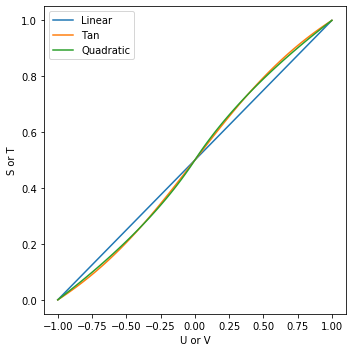

In [5]:
# Diagram of UV to ST mappings
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_xlabel('U or V')
ax.set_ylabel('S or T')

uv = np.linspace(-1.0, 1.0, 100)
st_linear = 0.5 * (uv + 1)
st_tan = 2 * (1 / np.pi) * (np.arctan(uv) + np.pi / 4)
st_quadratic = np.zeros_like(uv)
st_quadratic[uv >= 0] = 0.5 * np.sqrt(1 + 3 * uv[uv >= 0])
st_quadratic[uv < 0] = 1 - 0.5 * np.sqrt(1 - 3 * uv[uv < 0])

plt.plot(uv, st_linear, label='Linear')
plt.plot(uv, st_tan, label='Tan')
plt.plot(uv, st_quadratic, label='Quadratic')

ax.legend()
fig.tight_layout()
fig.savefig('../../docs/source/_static/uv_to_st_projections.svg', transparent=False, pad_inches=0)
fig.savefig('../../docs/source/_static/uv_to_st_projections.png', transparent=False, pad_inches=0)

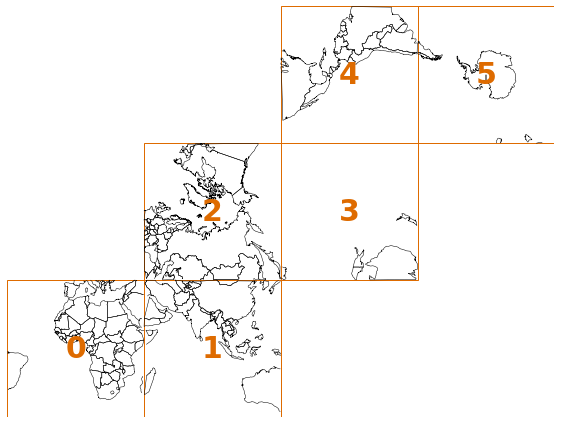

In [6]:
# Diagram of UV cube
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.set_aspect(1)
ax.set_xlim(-1, 7)
ax.set_ylim(-1, 5)
ax.set_axis_off()

# Draw faces
for face in range(6):
    for shape in shapes:
        for geom in (shape.geoms if hasattr(shape, 'geoms') else [shape]):
            points = []
            for point in geom.exterior.coords:
                points.append(lat_lon_to_face_uv(point[1], point[0]))

            plt.plot(
                [p[1][0] + face_to_uv_offset(p[0])[0] for p in points if p[0] == face],
                [p[1][1] + face_to_uv_offset(p[0])[1] for p in points if p[0] == face],
                linewidth=0.5, color='black'
            )

for face in range(6):
    centre = face_to_uv_offset(face)
    origin = np.array((-1, -1)) + centre
    ax.annotate(
        str(face), centre, color='#de6b00', fontsize=30, fontweight='bold',
        horizontalalignment='center', verticalalignment='center'
    )
    ax.add_patch(patches.Rectangle(origin, 2, 2, linewidth=1, edgecolor='#de6b00', facecolor='none'))

fig.tight_layout()
fig.savefig('../../docs/source/_static/cube_unwrapped.svg', transparent=False, pad_inches=0)
fig.savefig('../../docs/source/_static/cube_unwrapped.png', transparent=False, pad_inches=0)

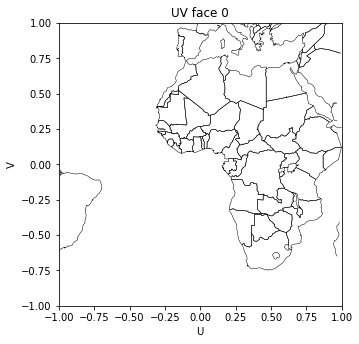

In [7]:
# Diagram of UV for face 0
face = 0

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_title('UV face 0')
ax.set_aspect(1)
ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

for shape in shapes:
    for geom in (shape.geoms if hasattr(shape, 'geoms') else [shape]):
        points = []
        for point in geom.exterior.coords:
            points.append(lat_lon_to_face_uv(point[1], point[0]))

        plt.plot(
            [p[1][0] for p in points if p[0] == face],
            [p[1][1] for p in points if p[0] == face],
            linewidth=0.5, color='black'
        )

fig.tight_layout()
fig.savefig('../../docs/source/_static/uv_face_0.svg', transparent=False, pad_inches=0)
fig.savefig('../../docs/source/_static/uv_face_0.png', transparent=False, pad_inches=0)

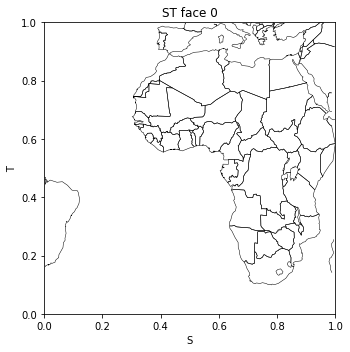

In [8]:
# Diagram of ST for face 0
face = 0

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_title('ST face 0')
ax.set_aspect(1)
ax.set_xlabel('S')
ax.set_ylabel('T')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

for shape in shapes:
    for geom in (shape.geoms if hasattr(shape, 'geoms') else [shape]):
        points = []
        for point in geom.exterior.coords:
            f, uv = lat_lon_to_face_uv(point[1], point[0])
            st = (s2cell._s2_uv_to_st(uv[0]), s2cell._s2_uv_to_st(uv[1]))
            points.append((f, st))
        
        plt.plot(
            [p[1][0] for p in points if p[0] == face],
            [p[1][1] for p in points if p[0] == face],
            linewidth=0.5, color='black'
        )

fig.tight_layout()
fig.savefig('../../docs/source/_static/st_face_0.svg', transparent=False, pad_inches=0)
fig.savefig('../../docs/source/_static/st_face_0.png', transparent=False, pad_inches=0)